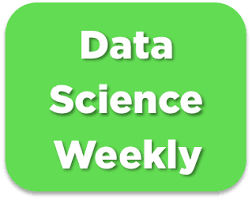

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, accuracy_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# import graphviz
from sklearn.tree import export_graphviz

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [28]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [29]:
valeur_palier_haut = data['age'].mean() + 3*data['age'].std()
valeur_palier_bas = data['age'].mean() - 3*data['age'].std()
outlier_condition = (data['age'] > valeur_palier_haut) | (data['age'] < valeur_palier_bas)
data = data[~outlier_condition]
data_sample = data.sample(10000)

In [30]:
target_variable = 'converted'
features_list = data.drop(columns=[target_variable]).columns
numeric_indices = [0]
categorical_indices = []


In [31]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]
data['convert2'] = str(data['converted']>0)
to_stratify = data['country']+ data['convert2']+data["source"] 

## Training pipeline

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=to_stratify)

numeric_features = ['age','total_pages_visited']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

categorical_features = ['country','new_user','source']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



## Modèle Décision Tree 'entropy'
C’est un arbre de décision pour la classification binaire qui utilise le critère d’entropie pour choisir les meilleurs splits.

Le modèle construit un arbre en divisant les données de manière à maximiser l’information gagnée à chaque séparation, ce qui permet de mieux distinguer les utilisateurs qui se convertissent (classe 1) de ceux qui ne le font pas (classe 0).

Ce modèle offre des leviers d’optimisation du F1-score via des hyperparamètres que l'on ajustera grace à un GridSearch.

le Decision Tree permet de capturer un maximum de conversions, et avec un bon réglage des hyperparamètres, il peut contribuer à maximiser le F1-score, en équilibrant précision et recall

In [33]:
# Grid of values to be tested
tree_classifier = DecisionTreeClassifier(criterion='entropy')
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', tree_classifier)])
params = {
    "classifier__max_depth": [8, 10, 15, 20],
    "classifier__min_samples_leaf": [2, 5, 10],
    "classifier__min_samples_split": [2, 4, 8]
}
gridsearch = GridSearchCV(pipeline, param_grid=params, cv=10, verbose=2)
gridsearch.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time= 

Le GridSearch nous a permis d’identifier les meilleurs hyperparamètres pour ce modèle.
Nous allons maintenant les appliquer à notre modèle final.

In [34]:
# Predictions on training set
params = {"max_depth": 1,"min_samples_leaf": 5,"min_samples_split": 4}
best_tree_classifier = DecisionTreeClassifier(criterion='entropy', **params)
model_tree = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', best_tree_classifier)])
model_tree.fit(X_train, Y_train)




,steps,"[('preprocessor', ...), ('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
Y_train_pred = model_tree.predict(X_train)

Y_test_pred = model_tree.predict(X_test)

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on training set :  0.6759147777835942
f1-score on test set :  0.6844968268359021


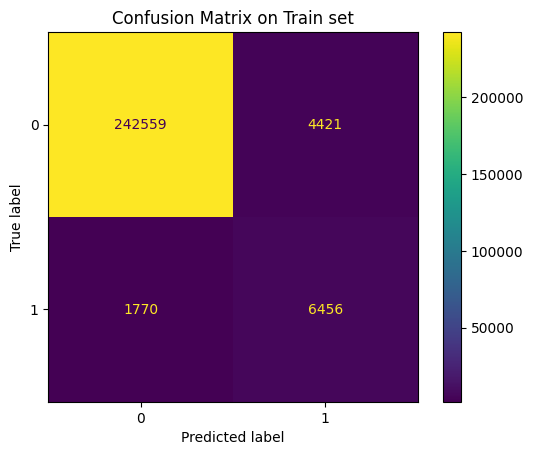

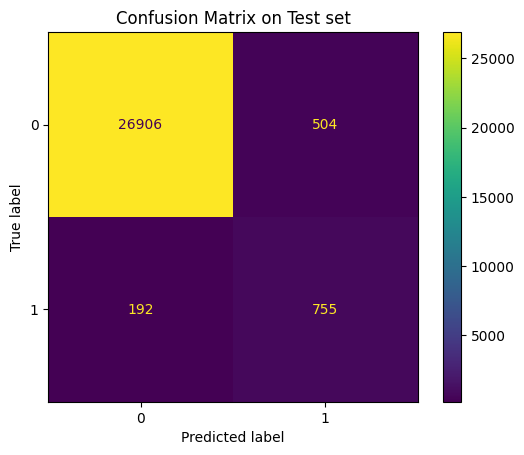

In [36]:
# Visualisation de la matrice de confusion
_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Train set"
)  
ConfusionMatrixDisplay.from_estimator(
    model_tree, X_train, Y_train, ax=ax
)  
plt.show()

_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Test set"
)  
ConfusionMatrixDisplay.from_estimator(
    model_tree, X_test, Y_test, ax=ax
)  
plt.show()


In [37]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))

print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))

Confusion matrix on train set : 
[[242559   4421]
 [  1770   6456]]
Confusion matrix on test set : 
[[26906   504]
 [  192   755]]


### Analyse comparative

* Vrais négatifs (TN = non-conversions correctement détectées)

LogReg : 27 200

Decision_Tree : 26 906

Decision_Tree fait légèrement moins bien sur les non-conversions.

* Faux positifs (FP = prédictions de conversion incorrectes)

LogReg : 166

Decision_Tree : 504

Decision_Tree prédit beaucoup plus de conversions erronées → précision plus faible.

* Faux négatifs (FN = conversions manquées)

LogReg : 266

Decision_Tree : 192

Decision_Tree perd moins de conversions → meilleur recall sur la classe 1.

* Vrais positifs (TP = conversions correctement détectées)

LogReg : 725

Decision_Tree : 755
Decision_Tree détecte plus de conversions réelles → recall supérieur.

## Conclusion

Decision_Tree : détecte plus de conversions, mais sacrifie la précision donc le F1-score pourrait être légèrement inférieur selon le compromis.

Régression logistique : meilleur équilibre précision/recall, cela reste le choix optimal pour notre objectif principal qui est d’améliorer le F1-score global.

# Conclusion finale

Parmi tous les modèles testés :

XGBoost et Decision Tree montrent des comportements opposés (précision forte pour l’un, recall fort pour l’autre), mais aucun ne parvient à surpasser le compromis de la régression logistique.

La régression logistique améliorée (avec pondération des classes et stratify enrichi) reste le meilleur choix pour ce problème, car elle maximise le F1-score, ce qui correspond directement à notre objectif principal.

Cela montre qu’un modèle simple mais bien calibré peut surpasser des modèles plus complexes, dès lors que la métrique choisie (ici F1) est bien optimisée.

## Entraînement du modèle sur l’ensemble des données pour la prédiction finale

In [38]:
# On concatene notre ensemble d'entraînement et notre ensemble de test pour entraîner notre meilleur modèle sur toutes les données avec étiquettes
X = pd.concat([X_train,X_test],axis=0)
Y = pd.concat([Y_train,Y_test],axis=0)

model_tree.fit(X,Y)

,steps,"[('preprocessor', ...), ('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
# On charge les données sans étiquettes et on prédit les étiquettes avec notre meilleur Decision_Tree
data_without_labels = pd.read_csv('conversion_data_test.csv')

X_without_labels = data_without_labels.loc[:, features_list]

Y_pred = model_tree.predict(X_without_labels)

data = {'converted': Y_pred}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_MARC-treeclass3.csv', index=False)